In [1]:
import torch
import numpy as np
import argparse
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
from torch.nn import MSELoss, L1Loss
import os
from matplotlib import pyplot as plt

In [24]:
df_raw = pd.read_csv("../datasets/AirQualityUCI.csv")
df_raw.replace(to_replace=-200, value=np.nan, inplace=True)
border = [0,int(len(df_raw)*0.8),len(df_raw)]
cols_data = df_raw.columns[2:] #change for different data
df_data = df_raw[cols_data]
data = df_data.values
test = True
if not test:
    data_x = data[border[0]:border[1]]
else:
    data_x = data[border[1]:border[2]]

orig_data = []
observed_mask = []
seq_len = 36
length = len(data_x)-seq_len+1
for i in range(length):
    orig_data.append(data_x[i:i+seq_len])
    observed_mask.append((~np.isnan(data_x[i:i+seq_len])).astype(int))
imputed_folder = "../results/aq_mv_imputation_novb/"
if test:
    imputed_path = os.path.join(imputed_folder,"test_samples.npy")
    mask_path = os.path.join(imputed_folder,"test_masks.npy")
    gt_path = os.path.join(imputed_folder,"test_gt.npy")
else:
    imputed_path = os.path.join(imputed_folder,"train_samples.npy")
    mask_path = os.path.join(imputed_folder,"train_masks.npy")
    gt_path = os.path.join(imputed_folder,"train_gt.npy")
synthetic_data = np.load(imputed_path)
gt_data = np.load(gt_path)
target_mask = np.load(mask_path)

scaler = StandardScaler()
scaler.fit(df_data[border[0]:border[1]].values)
# min_max_scaler = MinMaxScaler()
# min_max_scaler.fit(df_data[border[0]:border[1]].values)

StandardScaler()

In [25]:
target_mask.shape,gt_data.shape,synthetic_data.shape

((1837, 13, 36), (1837, 13, 36), (18370, 13, 36))

In [26]:
synthetic_data = np.reshape(synthetic_data,newshape=(gt_data.shape[0],-1,gt_data.shape[1],gt_data.shape[2]))
synthetic_data.shape

(1837, 10, 13, 36)

In [27]:
low_q = np.quantile(synthetic_data,0.05,axis=1)
high_q = np.quantile(synthetic_data,0.95,axis=1)
mid_q = np.quantile(synthetic_data,0.5,axis=1)

In [65]:
def geom_noise_mask_single(L, lm, masking_ratio):
    """
    Randomly create a boolean mask of length `L`, consisting of subsequences of average length lm, masking with 0s a `masking_ratio`
    proportion of the sequence L. The length of masking subsequences and intervals follow a geometric distribution.
    Args:
        L: length of mask and sequence to be masked
        lm: average length of masking subsequences (streaks of 0s)
        masking_ratio: proportion of L to be masked

    Returns:
        (L,) boolean numpy array intended to mask ('drop') with 0s a sequence of length L
    """
    keep_mask = np.ones(L, dtype=bool)
    p_m = 1 / lm  # probability of each masking sequence stopping. parameter of geometric distribution.
    p_u = p_m * masking_ratio / (1 - masking_ratio)
    # probability of each unmasked sequence stopping. parameter of geometric distribution.
    p = [p_m, p_u]

    # Start in state 0 with masking_ratio probability
    state = int(np.random.rand() > masking_ratio)  # state 0 means masking, 1 means not masking
    for i in range(L):
        keep_mask[i] = state  # here it happens that state and masking value corresponding to state are identical
        if np.random.rand() < p[state]:
            state = 1 - state

    return keep_mask.astype(int)

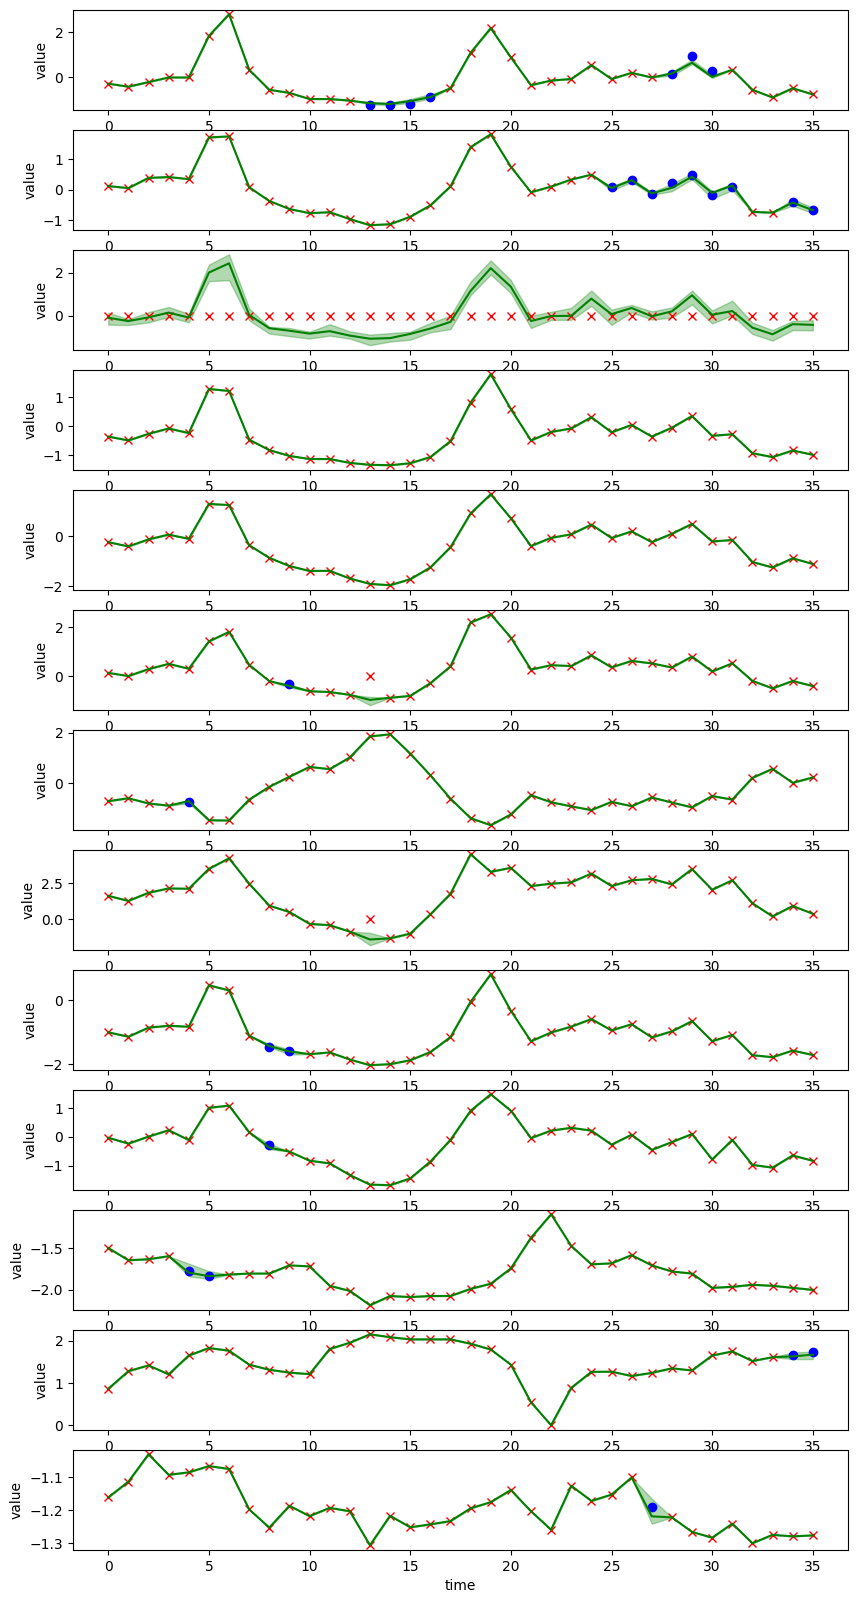

In [28]:
i = 863
feat_dim = synthetic_data.shape[2] 
fig, axes = plt.subplots(nrows=feat_dim, ncols=1, figsize=(10, 20))
for feat_idx in range(feat_dim):
    df_x = pd.DataFrame({"x": np.arange(0, seq_len), "val": gt_data[i, feat_idx, :],
                         "y": (1-target_mask)[i, feat_idx, :]})
    df_x = df_x[df_x.y!=0]

    df_o = pd.DataFrame({"x": np.arange(0, seq_len), "val": gt_data[i, feat_idx, :],
                         "y": target_mask[i, feat_idx, :]})
    df_o = df_o[df_o.y!=0]
    axes[feat_idx].plot(df_o.x, df_o.val, color='b', marker='o', linestyle='None')
    axes[feat_idx].plot(df_x.x, df_x.val, color='r', marker='x', linestyle='None')
    axes[feat_idx].plot(range(0, seq_len), mid_q[i, feat_idx, :], color='g', linestyle='solid', label='Diffusion-TS')
    axes[feat_idx].fill_between(range(0, seq_len), low_q[i, feat_idx,:],high_q[i,feat_idx, :], color='g', alpha = 0.3)
    plt.setp(axes[feat_idx], ylabel='value')
    if feat_idx == feat_dim-1:
        plt.setp(axes[-1], xlabel='time')
    # axes[feat_idx].set_ylim(-3, 3)
plt.show()

In [6]:
def process_mask(x,mask,missing_length = 3, missing_ratio = 0.1):
    x = x * mask
    cond_masks = torch.empty_like(x, dtype=torch.long)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            cond_mask = geom_noise_mask_single(x[i,j].shape[0], missing_length, missing_ratio)
            cond_masks[i,j] = torch.tensor(cond_mask, device=x.device)*mask[i,j]
    return x*cond_masks, cond_masks

In [9]:
from imputation_metrics import mse_withmask, mae_withmask, calc_quantile_CRPS, calc_quantile_CRPS_sum

In [10]:
target_mask.shape

(7450, 13, 36)

In [11]:
gt_data.shape

(7450, 13, 36)

In [12]:
synthetic_data.shape

(7450, 10, 13, 36)

In [29]:
mse_withmask(torch.Tensor(mid_q),torch.Tensor(gt_data),torch.Tensor(target_mask))

tensor(0.0317)

In [30]:
torch.sqrt(mse_withmask(torch.Tensor(mid_q),torch.Tensor(gt_data),torch.Tensor(target_mask)))

tensor(0.1781)

In [31]:
mae_withmask(torch.Tensor(mid_q),torch.Tensor(gt_data),torch.Tensor(target_mask))

tensor(0.0953)

In [32]:
calc_quantile_CRPS(torch.Tensor(gt_data),torch.Tensor(synthetic_data),torch.Tensor(target_mask),mean_scaler=0,scaler=1)

0.07418388441989296

In [20]:
unormzalized_gt_data = []
for g in gt_data:
    unormzalized_gt_data.append(np.transpose(np.transpose(g)*scaler.scale_+scaler.mean_))
unormzalized_gt_data = np.array(unormzalized_gt_data)
unormalized_synthetic_data = []
for i in range(len(synthetic_data)):
    for j in range(len(synthetic_data[i])):
        s = synthetic_data[i][j]
        unormalized_synthetic_data.append(np.transpose(np.transpose(s)*scaler.scale_+scaler.mean_))
unormalized_synthetic_data = np.array(unormalized_synthetic_data).reshape(synthetic_data.shape[0],-1,synthetic_data.shape[2],synthetic_data.shape[3])
unormzalized_gt_data.shape,unormalized_synthetic_data.shape

((1837, 13, 36), (1837, 10, 13, 36))

In [21]:
calc_quantile_CRPS(torch.Tensor(unormzalized_gt_data),torch.Tensor(unormalized_synthetic_data),torch.Tensor(target_mask),mean_scaler=0,scaler=1)

torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36]) torch.Size([1837, 13, 36])
torch.Size([1837, 13, 36]) t

0.023528560211783962

In [31]:
mse_withmask(torch.Tensor(synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(gt_data),torch.Tensor(target_mask))

tensor(0.0415)

In [33]:
torch.sqrt(mse_withmask(torch.Tensor(synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(gt_data),torch.Tensor(target_mask)))

tensor(0.2036)

In [32]:
mae_withmask(torch.Tensor(synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(gt_data),torch.Tensor(target_mask))

tensor(0.1158)

In [34]:
mse_withmask(torch.Tensor(unormalized_synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(unormzalized_gt_data),torch.Tensor(target_mask))

tensor(1164.2112)

In [35]:
torch.sqrt(mse_withmask(torch.Tensor(unormalized_synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(unormzalized_gt_data),torch.Tensor(target_mask)))

tensor(34.1205)

In [36]:
mae_withmask(torch.Tensor(unormalized_synthetic_data).chunk(10,dim=1)[0].view(-1,13,36),torch.Tensor(unormzalized_gt_data),torch.Tensor(target_mask))

tensor(16.2292)